In [37]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem, DataStructs
import math
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.DataStructs import TanimotoSimilarity
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') 



## Data cleaning 
In this chapter we check which of the datsets we have are usefull for our purpose

In [17]:
df_curatedSol = pd.read_csv('../Data/CuratedSol.csv')
df_biogen = pd.read_csv('../Data/Biogen.csv')
df_bioavailability = pd.read_csv('../Data/Bioavailibility.csv')
df_ESOL = pd.read_csv('../Data/ESOL.csv')
df_OCHEM = pd.read_csv('../Data/OCHEM_Sol.csv')
df_WEI_Bioav = pd.read_csv('../Data/HOB_Bioavailibility_Wei_2022.csv')
df_merged_Bioavailibility = pd.read_csv('../Data/Merged_Bioavailibility.csv')
df_merged_Solubility = pd.read_csv('../Data/Merged_solubility.csv')

In [18]:
#df_curatedSol.head()
#df_bioavailability.head() #995
#df_biogen.head() #3521
#df_ESOL.head() #1128
#df_Ochem.head(100) 
#df_merged_Bioavailibility.shape

## Functions for data preperation

In [19]:
def canonicalize(Dataframe: pd.DataFrame, column_name: str):
    
    """Canonicalizes the SMILES from Dataframe. A column called 'SMILES' is requiered

    Args: 
        Dataframe with 'SMILES' column contaning smiles. 
    """
    
    Dataframe[column_name] = Dataframe[column_name].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x))) #canonicalize smiles from a Dataframe                                          
    

In [20]:
def add_Lipinski_descriptors(Dataframe: pd.DataFrame, column_name: str):

   """This function takes a dataframe and adds the Lipinski descriptors 
      (Molecular weight in Dalton, Number of H-acceptors and donors and the 
      logP value) to it. It also adds a column witch says if the molecule follows 
      the Lipinski's rule of five. (1= yes, 0= no)
    
   Args: 
      Pandas Dataframe with a column witch contains the SMILES strings.
   """
   #calcculats the molecular weight of the molecules
   Dataframe['MolW(Da)'] = Dataframe[column_name].apply(lambda x: Chem.Descriptors.MolWt(Chem.MolFromSmiles(x)))
   #calculates the number of H-acceptors and donors
   Dataframe['NumHAcceptors'] = Dataframe[column_name].apply(lambda x: Chem.Descriptors.NumHAcceptors(Chem.MolFromSmiles(x)))
   #calculates the number of H-acceptors and donors
   Dataframe['NumHDonors'] = Dataframe[column_name].apply(lambda x: Chem.Descriptors.NumHDonors(Chem.MolFromSmiles(x)))
   #calculates the logP value
   Dataframe['LogP'] = Dataframe[column_name].apply(lambda x: Chem.Descriptors.MolLogP(Chem.MolFromSmiles(x)))

   Dataframe['Lipinski_rule'] = Dataframe.apply(lambda x: 1 if x['MolW(Da)'] <= 500 and x['NumHAcceptors'] <= 10 and x['NumHDonors'] <= 5 and x['LogP'] <= 5 else 0, axis=1)

In [21]:
def convert_solubility(Dataframe: pd.DataFrame, column_solubility: str, column_Mw: str):
    """
    Converts the solubility values from a DataFrame from log(ug/mL) to log(mol/L).
    
    Args:
        dataframe (pd.DataFrame): DataFrame with the solubility values.
        column_solubility (str): Column name containing solubility values in log(ug/L).
        column_Mw (str): Column name containing molecular weight (Mw) values in g/mol.
    
    Returns:
        pd.DataFrame: DataFrame with an additional column for solubility in log(mol/L).
    """
    # Define a function to apply to each row
    def convert_log_solubility(row):
        log_ug_per_L = row[column_solubility]
        molar_mass = row[column_Mw]
        # Perform the conversion
        log_mol_per_L = log_ug_per_L - 3 - math.log10(molar_mass)
        return log_mol_per_L
    
    # Apply the conversion function to each row and create a new column
    Dataframe['Solubility_log(mol/L)'] = Dataframe.apply(convert_log_solubility, axis=1)
    
    return Dataframe

In [22]:
def calc_Solubility_molL(Dataframe: pd.DataFrame, coulmn_name: str):
    
    """Calculates the solubility in mol/L from a Dataframe with a column containing solubility in log(mol/L).

    Args: 
        Dataframe with column containing solubility values in log(mol/L).
    """
    #converts the solubility from log(mol/L) to mol/L
    Dataframe['Solubility(mol/L)'] = Dataframe[coulmn_name].apply(lambda x: 10**x)

    return Dataframe

In [23]:
def drop_analysis(Dataframe: pd.DataFrame):

    """Drops duplicates and missing SOL data from a Dataframe.

    Args:
        Dataframe with a column containing SMILES strings and a column containing solubility values.
    """
    
    len = Dataframe.shape[0]
    #drops duplicates and missing solubility data
    data = Dataframe.drop_duplicates(subset="SMILES", keep='first')
    data2 = Dataframe.dropna(subset=['Solubility_log(mol/L)'])
    data3 = Dataframe.dropna(subset=['Solubility(mol/L)']).drop_duplicates(subset="SMILES", keep='first')
    print(f"dropped (missing SOL data): {len - data2.shape[0]}\ndropped (duplicates): {len - data.shape[0]}\ndropped (total): {len - data3.shape[0]}")

    return data3

# Preparing data for combining
Here we canonicalize the SMILES strings, add the Lipinski descriptors and add the Solubility in mol/L to the Dataframe. The Water Solubility in all compounds is given as log(mol/L).

In [24]:
canonicalize(df_OCHEM, 'SMILES')
add_Lipinski_descriptors(df_OCHEM, 'SMILES')
calc_Solubility_molL(df_OCHEM, 'Solubility_log(mol/L)')
#saving as csv
df_OCHEM.to_csv('../Data/OCHEM_Sol.csv', index=False)
df_OCHEM.shape #5000

(5000, 13)

In [25]:
canonicalize(df_ESOL, 'SMILES')
add_Lipinski_descriptors(df_ESOL, 'SMILES')
calc_Solubility_molL(df_ESOL, 'Solubility_log(mol/L)')
#saving as csv
df_ESOL.to_csv('../Data/ESOL.csv', index=False)
df_ESOL.shape #1128

(1128, 16)

In [26]:
canonicalize(df_biogen, 'SMILES')
add_Lipinski_descriptors(df_biogen, 'SMILES')
calc_Solubility_molL(df_biogen, 'Solubility_log(mol/L)')
#saving as csv
df_biogen.to_csv('../Data/Biogen.csv', index=False)
df_biogen.shape #3521

(3521, 17)

In [27]:
canonicalize(df_curatedSol, 'SMILES')
add_Lipinski_descriptors(df_curatedSol, 'SMILES')
calc_Solubility_molL(df_curatedSol, 'Solubility_log(mol/L)')
#saving as csv
df_curatedSol.to_csv('../Data/CuratedSol.csv', index=False)
df_curatedSol.shape #9982

(9982, 30)

## Combining data
Combing all the solubility data (ESOL, curated, Biogen, OCHEM) to one big dataframe which contains SMILES, Solubility in log(mol/L), Mw and Lipinski descriptors

In [28]:
df_merged_1 = pd.merge(df_curatedSol, df_biogen, on=['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'], how='outer').filter(['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'])
df_merged_1_cleand = drop_analysis(df_merged_1)

dropped (missing SOL data): 1348
dropped (duplicates): 23
dropped (total): 1356


Here we saw: the biogen datasets has a lot of missing water solubility data.

In [29]:
df_merged_2 = pd.merge(df_merged_1_cleand, df_ESOL, on=['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'], how='outer').filter(['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'])
df_merged_2_cleand = drop_analysis(df_merged_2)

dropped (missing SOL data): 0
dropped (duplicates): 841
dropped (total): 841


Here we saw: the ESOL data contained some duplicates

In [30]:
df_merged_3 = pd.merge(df_merged_2_cleand, df_OCHEM, on=['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'], how='outer').filter(['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'])
df_merged_3_cleand = drop_analysis(df_merged_3)

dropped (missing SOL data): 0
dropped (duplicates): 3967
dropped (total): 3967


Here we saw: most of the OCHEM Smiles were already in the other datasets

In [31]:
df_merged_3_cleand.to_csv('../Data/Merged_solubility.csv', index=False)

## Visualization of the Solubility Data
In this chapter we will create some diagramms (Distribution, heat maps) to analyse the data.

In [32]:
df_merged_Solubility.head()

,SMILES,Solubility_log(mol/L),Solubility(mol/L),MolW(Da),NumHAcceptors,NumHDonors,LogP,Lipinski_rule
0,B#N,-6.394784,4.029171e-07,24.819,1,0,-0.36572,1
1,B12B3B4B1C234,-4.742403,1.809660e-05,55.259,0,0,-1.30840,1
2,Br/C=C/Br,-1.741500,1.813427e-02,185.846,0,0,2.24740,1
3,Br/C=C\Br,-1.319500,4.791815e-02,185.846,0,0,2.24740,1
4,BrC(Br)(Br)Br,-3.140400,7.237690e-04,331.627,0,0,3.17730,1


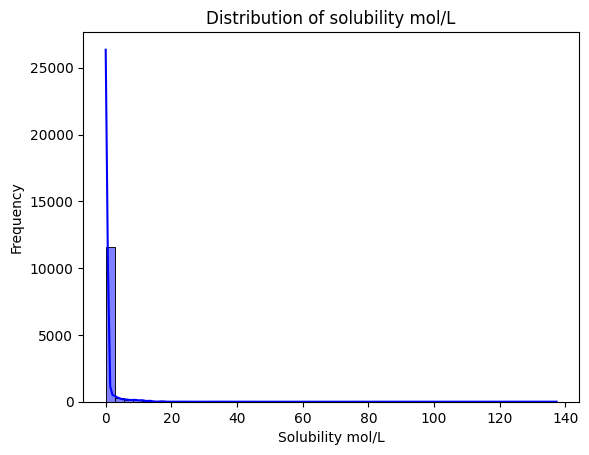

In [34]:
#plotting the distribution of solubility mol/L

sns.histplot(data=df_merged_Solubility, x='Solubility(mol/L)', kde=True, bins=50, color='blue')
plt.title('Distribution of solubility mol/L')
plt.xlabel('Solubility mol/L')
plt.ylabel('Frequency')
plt.show()

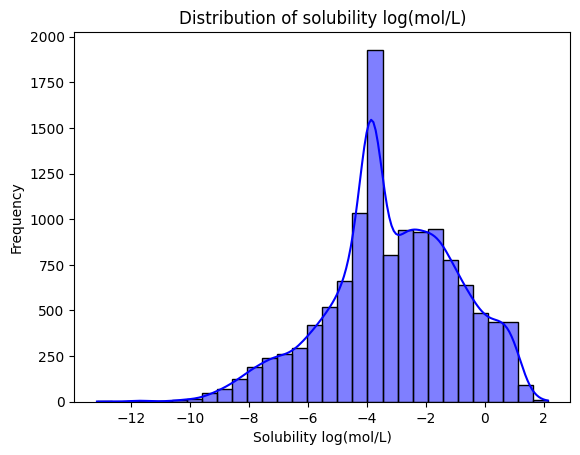

In [29]:
#plotting the distribution of solubility log(mol/L) 

sns.histplot(data=df_merged_Solubility, x='Solubility_log(mol/L)', kde=True, bins=30, color='blue')
plt.title('Distribution of solubility log(mol/L)')
plt.xlabel('Solubility log(mol/L)')
plt.ylabel('Frequency')
plt.show()

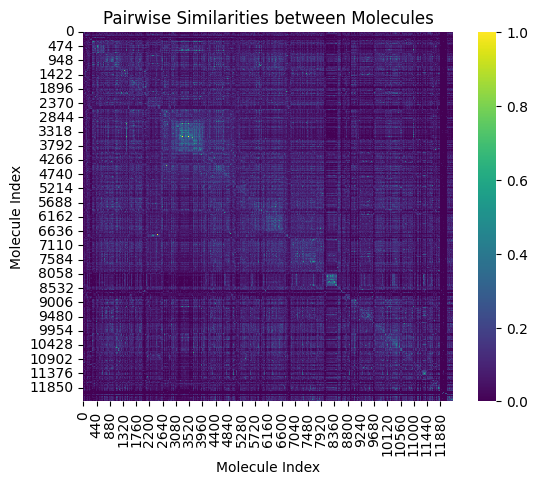

In [33]:
#Heat map for Tanimoto similarity of the molecules

smiles_list = df_merged_Solubility['SMILES'].tolist()

# Convert SMILES to RDKit Mol objects
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles) is not None]

# Calculate fingerprints
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in molecules]

# Calculate pairwise similarities
similarity_matrix = np.zeros((len(fps), len(fps)))
for i in range(len(fps)):
    for j in range(i+1, len(fps)):
        similarity = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

# Visualize the similarity matrix as a heatmap
sns.heatmap(similarity_matrix, cmap='viridis', square=True)
plt.xlabel('Molecule Index')
plt.ylabel('Molecule Index')
plt.title('Pairwise Similarities between Molecules')
plt.show()

In [34]:
# Calculate the average Tanimoto similarity from the molecules of the merged solubility dataset

average_similarity = np.mean(similarities)
print("Average similarity:", average_similarity)

Average similarity: 0.057728841647710374


## Bioavailibility Data
In this chapter we check out our two bioavailibility sets and prepearing for combining

In [85]:
def calc_logK(Dataframe: pd.DataFrame, column_name: str):
    """
    Calculates the logK from a DataFrame with a column containing K values.

    Args:
        Dataframe with column containing %F values.
    """
    #converts the %F values to logK values
    Dataframe['logK(%F)'] = Dataframe[column_name].apply(lambda x: math.log10(x/(100-x)))

    return Dataframe

In [48]:
#Prepeare the Bioavailibility data for combinig

df_bioavailability.rename(columns={'Updated SMILES': 'SMILES'}) #rename the column
canonicalize(df_bioavailability, 'SMILES')
add_Lipinski_descriptors(df_bioavailability, 'SMILES')
#saving as csv
df_bioavailability.to_csv('../Data/Bioavailibility.csv', index=False)

In [51]:
#preaparing df_WEI_Bioav for combing both datasets

df_WEI_Bioav = df_WEI_Bioav.rename(columns={'smile': 'SMILES', 'value': '%F'}) #rename the column
df_WEI_Bioav['%F'] = df_WEI_Bioav['%F'].astype(float) #convert the column to float

canonicalize(df_WEI_Bioav, 'SMILES')
add_Lipinski_descriptors(df_WEI_Bioav, 'SMILES')
#saving as csv
df_WEI_Bioav.to_csv('../Data/HOB_Bioavailibility_Wei_2022.csv', index=False)


In [72]:
#change 100% and 0% to 99.99% and 0.01% to avoid log(0) in calc_logK
df_WEI_Bioav['%F'] = df_WEI_Bioav['%F'].replace({100.0: 99.99, 0.0: 0.01})

,Name,SMILES,%F,label_cutoff_50%,our model predition_50%,label_cutoff_20%,our model predition_20%,MolW(Da),NumHAcceptors,NumHDonors,LogP,Lipinski_rule
0,sulfadiazine,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,90.00,1,1,1.0,1.0,250.283,5,2,0.85960,1
1,clofarabine,Nc1nc(Cl)nc2c1ncn2C1OC(CO)C(O)C1F,50.00,1,1,1.0,1.0,303.681,8,3,-0.34940,1
2,sulfamethoxazole,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,99.00,1,1,1.0,1.0,253.283,5,2,1.36602,1
3,tolazoline,c1ccc(CC2=NCCN2)cc1,90.00,1,1,1.0,1.0,160.220,2,1,1.23080,1
4,cotinine,CN1C(=O)CCC1c1cccnc1,97.00,1,1,1.0,1.0,176.219,2,0,1.37490,1
5,methylaminorex,CC1NC(=N)OC1c1ccccc1,62.00,1,1,1.0,1.0,176.219,2,2,1.67077,1
6,ritipenem,CC(O)C1C(=O)N2C(C(=O)O)=C(COC(=N)O)SC12,37.00,0,0,1.0,1.0,288.281,6,4,-0.29593,1
7,didanosine,OCC1CCC(n2cnc3c(O)ncnc32)O1,38.00,0,0,1.0,1.0,236.231,7,2,0.20180,1
8,tazobactam,CC1(Cn2ccnn2)C(C(=O)O)N2C(=O)CC2S1(=O)=O,0.01,0,0,0.0,0.0,300.296,7,1,-1.52320,1
9,phenylbutyrate,O=C(O)CCCc1ccccc1,78.00,1,1,1.0,1.0,164.204,1,1,2.09390,1


In [84]:
# Calculate logK values out of %F values
calc_logK(df_WEI_Bioav, '%F')
#saving as csv
df_WEI_Bioav.to_csv('../Data/HOB_Bioavailibility_Wei_2022.csv', index=False)

/var/folders/56/k5y5cj453pvcsblxlzlzn0340000gn/T/ipykernel_58741/3083283574.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


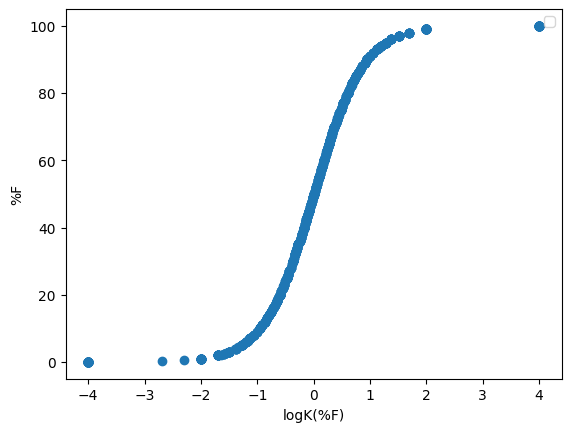

In [36]:
#checking out how the logK values relate to the %F values

fig, ax = plt.subplots()
ax.scatter(df_WEI_Bioav["logK(%F)"], df_WEI_Bioav["%F"])
ax.set_xlabel('logK(%F)')
ax.set_ylabel("%F")
ax.legend()

## Combining Bioavailibility data
In that chapter we finally combine our bioavailibility data and drop the overlapping data

In [93]:
#Merging the Bioavailibility datasets
df_merged_Bioavailibility = pd.merge(df_bioavailability, df_WEI_Bioav, on=['SMILES', '%F', 'logK(%F)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'], how='outer').filter(['SMILES', '%F', 'logK(%F)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'])

In [94]:
#drop duplicates from the merged dataset with preferance to the Bioavailibility.csv dataset

len = df_merged_Bioavailibility.shape[0]
df_after_drop = df_merged_Bioavailibility.drop_duplicates(subset="SMILES", keep='first')
print(f"dropped (duplicates): {len - df_after_drop.shape[0]}")
#saving as csv
df_after_drop.to_csv('../Data/Merged_Bioavailibility.csv', index=False)

dropped (duplicates): 442


A total of 442 compunds have the sam Smiles string

## Visualization of the Bioavailibility Data
In this chapter we will create some diagramms (Distribution, heat maps) to analyse the merged bioavailibility data.

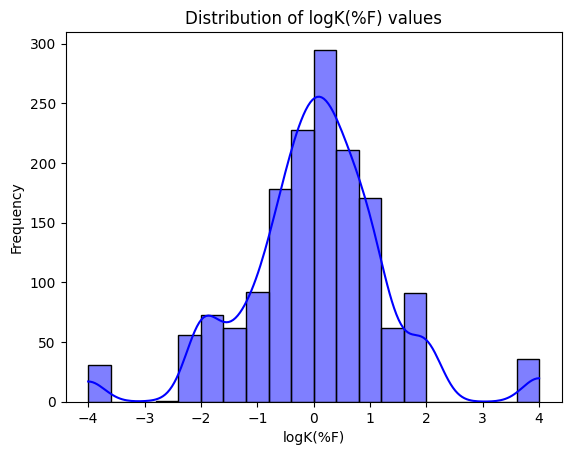

In [27]:
#plotting the distribution of logK(%F) values

sns.histplot(data=df_merged_Bioavailibility, x='logK(%F)', kde=True, bins=20, color='blue')
plt.title('Distribution of logK(%F) values')
plt.xlabel('logK(%F)')
plt.ylabel('Frequency')
plt.show()

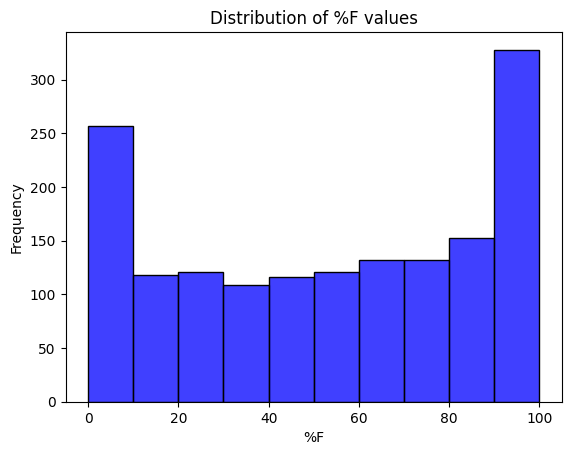

<Figure size 640x480 with 0 Axes>

In [26]:
#plotting the distribution of %F values

sns.histplot(data=df_merged_Bioavailibility, x='%F', kde=False, bins=10, color='blue', )
plt.title('Distribution of %F values')
plt.xlabel('%F')
plt.ylabel('Frequency')
plt.show()
plt.savefig('plot.png')

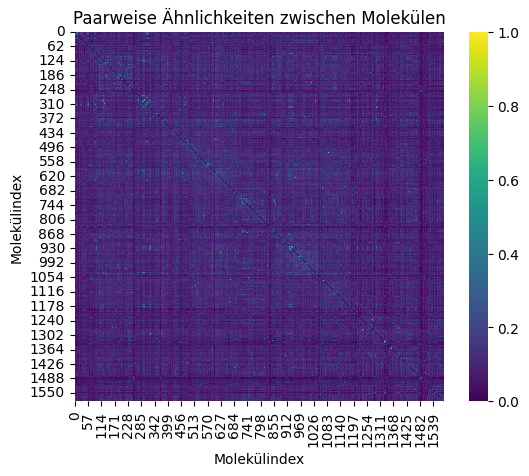

In [39]:
# Visulaization of the Tanimoto similarity of the molecules in the merged Bioavailibility dataset

smiles_list = df_merged_Bioavailibility['SMILES'].tolist()

# convert SMILES to RDKit Mol objects
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles) is not None]

# calculate fingerprints
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in molecules]

# calculate pairwise similarities
similarity_matrix = np.zeros((len(fps), len(fps)))
for i in range(len(fps)):
    for j in range(i+1, len(fps)):
        similarity = TanimotoSimilarity(fps[i], fps[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

# Visualize the similarity matrix as a heatmap
sns.heatmap(similarity_matrix, cmap='viridis', square=True)
plt.xlabel('Molekülindex')
plt.ylabel('Molekülindex')
plt.title('Paarweise Ähnlichkeiten zwischen Molekülen')
plt.show()

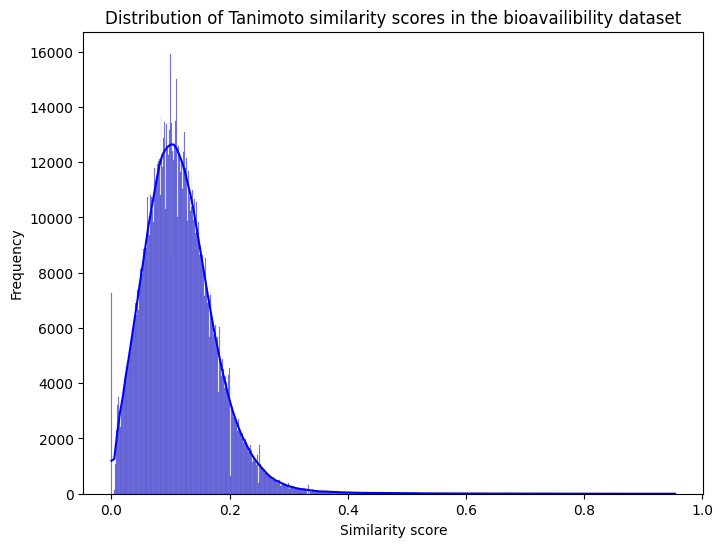

In [18]:
# Visualize the distribution of Tanimoto similarity scores in the bioavailibility dataset

# Calculate Tanimoto similarity
def calculate_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if mol1 is not None and mol2 is not None:
        fp1 = AllChem.GetMorganFingerprint(mol1, 2)  # Morgan fingerprint with radius 2
        fp2 = AllChem.GetMorganFingerprint(mol2, 2)
        similarity = AllChem.DataStructs.TanimotoSimilarity(fp1, fp2)
        return similarity
    else:
        return None

# Calculate similarity for each pair of SMILES in the DataFrame
similarities = []
for i in range(len(df_merged_Bioavailibility)):
    for j in range(i+1, len(df_merged_Bioavailibility)):
        similarity = calculate_similarity(df_merged_Bioavailibility['SMILES'][i], df_merged_Bioavailibility['SMILES'][j])
        if similarity is not None:
            similarities.append(similarity)

# Plot the distribution of similarity scores
plt.figure(figsize=(8, 6))
sns.histplot(similarities, kde=True, color='blue')
plt.title('Distribution of Tanimoto similarity scores in the bioavailibility dataset')
plt.xlabel('Similarity score')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Calculate the average Tanimoto similarity from the molecules of the merged bioavailibility dataset
average_similarity = np.mean(similarities)
print("Average similarity:", average_similarity)

Average similarity: 0.11581028036267685


## Checking overlapping Data
In this chapter we have a look in both of our datasets and check if there is some overlapping data based on the Smiles string.

In [40]:
def find_duplicates(list1: list, list2: list):

    """finds overlapping elements in a list and returns a list of them

    Args: 
         two lists 
    """

    duplicates = [] #list for saving overlapping elements

    unique_elements = set()

    for item in list1:
        if item in list2 and item not in unique_elements:
            duplicates.append(item)
            unique_elements.add(item)

    return duplicates #returns list of overlapping elements

In [42]:
#convert the SMILES column to a list
Bioavailibility_SMILES = df_merged_Bioavailibility['SMILES'].tolist()
Solubility_SMILES = df_merged_Solubility['SMILES'].tolist()

In [ ]:
overlapping_SMILES = find_duplicates(Bioavailibility_SMILES, Solubility_SMILES)
len(overlapping_SMILES)

In [64]:
#merging the overlapping data based on the SMILES column

merged_df = pd.merge(df_merged_Bioavailibility, df_merged_Solubility, on='SMILES', how='inner')
#saving as csv
merged_df.to_csv('../Data/overlapping_data.csv', index=False)

The data is now ready for the application in our machine learning models.